## Introduction

In [1]:
%pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.8/112.8 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.7 MB/s eta 0:00:00
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import erf
from time import time,sleep
import pandas as pd
from scipy.stats import norm
import yfinance
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import lognorm,norm

## Util functions

In [3]:
def compute_95ci_error(array : np.ndarray)->float:
  """
  Compute the Monte Carlo Confidence Interval value at 95% confidence level
    Value = mean +- CI
  returns : Confidence interval value (plus or minus)
  """
  n_paths = len(array)
  CI = n_paths / (n_paths-1) * array.std() * 1.96 / np.sqrt(n_paths)
  return CI

In [4]:
def plot_path(prices_path:np.ndarray,scale : float= 1.,xlabel=None,ylabel=None,title= None,plot_limit_path :int = 250,plot_end_price_distrib = False,distrib_fit = lognorm):
  """
    plot prices paths generated by the PathGenerator class
    can scale the output fig with the "scale" argument
  """
  plotabble = prices_path if len(prices_path.shape)==1 else prices_path if prices_path.shape[1] <100 else prices_path[:,:plot_limit_path]
  fig,axs = plt.subplots(1,1,figsize=(int(7*scale),int(5*scale)))
  ax = axs
  ax.plot(plotabble)
  ax.axvline(x=plotabble.shape[0]+1,color="black",linestyle='--', dashes=(2, 5),)
  ax.set_xlim((0,plotabble.shape[0]*1.05))
  if xlabel: ax.set_xlabel(xlabel)
  if ylabel: ax.set_ylabel(ylabel)
  if title: fig.suptitle(title,fontsize=20)

  if plot_end_price_distrib : 
    divider = make_axes_locatable(ax)
    ax_histy = divider.append_axes("right", 1.2, pad=0.2, sharey=ax)
    ax_histy.yaxis.set_tick_params(labelleft=False)

    bins = int((prices_path[-1].max() - prices_path[-1].min()) / 15)
    bins = bins if bins > 0 else 15
    
    ax_histy.hist(prices_path[-1],bins=bins,density=True,orientation='horizontal',color="skyblue",ec="black", alpha = 0.5)
    
    params = distrib_fit.fit(prices_path[-1])
    params,loc,scale = params[:-2],params[-2],params[-1]

    xmin,xmax = ax_histy.get_ylim()
    x=np.sort(prices_path[-1])
    x = np.linspace(xmin,xmax,1000)
    pdf_fitted = distrib_fit.pdf(x, *params, loc=loc, scale=scale) # fitted distribution
    ax_histy.plot(pdf_fitted,x,'r--', alpha = 0.5)

    ax_histy.spines['top'].set_visible(True)
    ax_histy.spines['right'].set_visible(True)
    ax_histy.spines['bottom'].set_visible(True)
    ax_histy.spines['left'].set_visible(True)
    ax_histy.set_xlabel("Density")
    # ax_histy.set_xticklabels(ax_histy.get_xticklabels()[1:])
  plt.tight_layout()
  plt.show()

In [5]:
def time_it(func):
  def wrapped(*args,**kwargs):
    start_time = time()
    res = func(*args,**kwargs)
    end_time = time()
    print(f"Execution time is {end_time - start_time : .2f} seconds")
    return res
  return wrapped

In [6]:
def time_it_func(func,*args,**kwargs):
    start_time = time()
    res = func(*args,**kwargs)
    end_time = time()
    return *res,end_time - start_time

## Path generator class

### Model and wrapper

In [7]:
def price_move_bachelier(S:np.ndarray,v:np.ndarray,dt:float,r:float,sigma:float):
    """
    Compute S_(t+dt) base on the vector of prices St (S) and market paremters
    Returns the price vector S(t+dt)
    """
    dwt = np.random.normal(size=(S.shape)) * np.sqrt(dt)
    dSt = r*S * dt + sigma * dwt
    return S + dSt,v

In [8]:
def price_move_black_scholes(S:np.ndarray,v:np.ndarray,dt:float,r:float,sigma:float):
    """
    Compute S_(t+dt) base on the vector of prices St (S) and market paremters
    Returns the price vector S(t+dt)
    """
    dwt = np.random.normal(size=(S.shape)) * np.sqrt(dt)
    dSt = r*S * dt + S * sigma * dwt
    return S + dSt,v

In [9]:
def price_move_Heston(S:np.ndarray,v:np.ndarray,dt:float,r:float,kappa:float,theta:float,vol_of_vol:float,rho:float):
    """
    Compute S_(t+dt) base on the vector of prices St (S) and market paremters
    Returns the price vector S(t+dt)
    S is a price vector (dim 1)
    """
    means = np.array([0.,0.])
    cov = np.array([[1,rho],[rho,1]])

    correlated_normal_variable = np.random.multivariate_normal(means,cov,size=S.size)
    dwt = correlated_normal_variable[:,0] *  np.sqrt(dt)
    dbt = correlated_normal_variable[:,1] * np.sqrt(dt)

    dvt = kappa*(theta-v) * dt + vol_of_vol * np.sqrt(v) * dbt
    v = v + dvt

    dSt = r*S * dt + S * np.sqrt(v) * dwt

    return S + dSt,v

In [10]:
class PathGenerator:
  """
  Used to generate prices path with fixed market setting :
      r : interest rate
      sigma : volatility
      T : maturity/stop time
      S0 : starting price of the asset
  
  Computes the increments of the asset price using the "price_move_function" argument and its arguments "price_move_function_args"
      price_move_function : function(price_vector,dt,**args)
      converted to function(price_vector,volatility_vectorr,dt) for normalization purposes using lambda function
  """
  def __init__(self,S0:float,r:float,T:float,sigma:float,price_move_function : callable,price_move_function_args : dict = {}):
      self.__S0 = S0
      self.__r = r
      self.__T = T
      self.__sigma = sigma
      self.__price_move_function = lambda S,v,dt : price_move_function(S=S,v=v,dt=dt,**price_move_function_args)
      self.__price_move_function_og = price_move_function
      self.__price_move_function_args = price_move_function_args

  def generate_path(self,n_paths :int ,n_steps : int,S_impact : float = 0.,seed=None) -> np.ndarray:
      """
        Generate n_paths paths with n_steps each using the market parameters and the "price_move_function" supplied at initialization
        Returns the path matrix (n_step x n_paths) 
      """
      np.random.seed(seed)
      S = np.zeros((n_steps+1,n_paths))    
      v = np.ones((n_steps+1,n_paths)) * (self.__sigma * self.__sigma)
      S[0,:] += self.__S0 + S_impact
      dt = self.__T / n_steps
      for step in range(1,n_steps+1):
        S[step],v[step] = self.__price_move_function(S=S[step-1],v=v[step-1],dt=dt)
      return S
  def get_r(self):
    return self.__r
  def get_sigma(self):
    return self.__sigma
  def get_T(self):
    return self.__T
  def get_S0(self):
    return self.__S0
  def set_sigma(self,sigma):
    self.__sigma = sigma
    if "sigma" in self.__price_move_function_args.keys():
      self.__price_move_function_args["sigma"] = sigma
      self.__price_move_function = lambda S,v,dt : self.__price_move_function_og(S=S,v=v,dt=dt,**self.__price_move_function_args)    

### Sample Paths under BSM, Bachelier Heston models

#### BSM

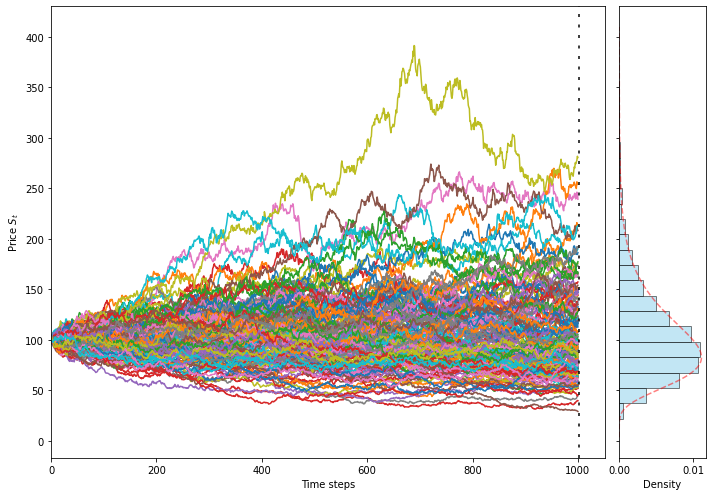

In [46]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
path = path_generator.generate_path(1,100).flatten()

plot_path(path_generator.generate_path(n_paths = 5000,n_steps = 1000),scale=1.5,
          plot_limit_path = 150,plot_end_price_distrib=True,distrib_fit=lognorm,
          xlabel = "Time steps",ylabel = "Price $S_t$")

#### Bachelier

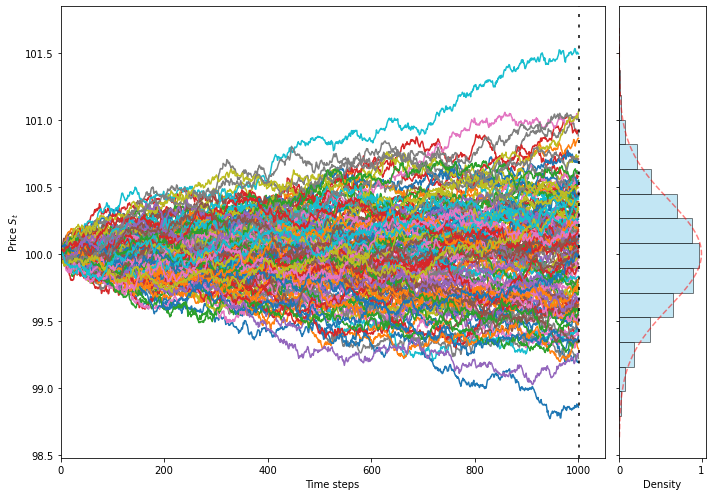

In [12]:
S0 = 100
r = 0.
T = 1
sigma = 0.4

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_bachelier,price_move_function_args={"r":r,"sigma":sigma})
path = path_generator.generate_path(1,100).flatten()

plot_path(path_generator.generate_path(n_paths = 5000,n_steps = 1000),scale=1.5,
          plot_limit_path = 150,plot_end_price_distrib=True,distrib_fit=norm,
          xlabel = "Time steps",ylabel = "Price $S_t$")

#### Heston

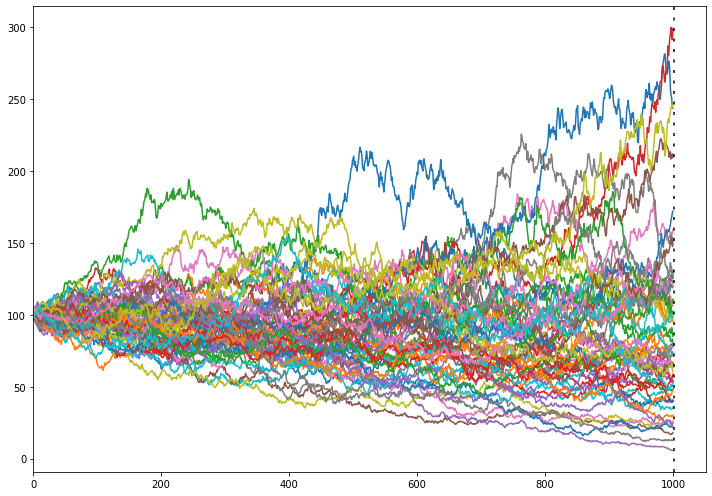

In [13]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
kappa = 1.5
theta = 0.5
vol_of_vol = 0.3
rho = -0.5

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})
plot_path(path_generator.generate_path(n_paths = 60,n_steps = 1000),scale=1.5)

## PayOff class

#### Class definition

In [14]:
class PayOff:
  """
  Used to compute the payoff of a derivative using "payoff_func" and its arguments "payoff_func_all_args"
  payoff_func is of type : function(price_vector,**args)->payoff
  It is refactored into type : function(price_vector)->payoff using lambda function
  Same for the derivative of the function payoff, used for the pathwise greek evaluation method
  """
  def __init__(self,payoff_func_all_args,**kwargs):
        self.__payoff_func = lambda x : payoff_func_all_args(x,**kwargs)

  def compute_payoff(self,price_paths : np.ndarray) -> np.ndarray:
        if len(price_paths.shape)==1:
          return self.__payoff_func(price_paths)
        else:
          return np.apply_along_axis(self.__payoff_func,axis = 0,arr = price_paths)

#### Derivative example : European and Asian options

In [15]:
def geometric_asian_call(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of an asian call option with strike K and geometric mean
    Uses the logarithmic transformation to avoid overflow with the power operator
    """
    n = price_vector.shape[0]
    log_sum = np.sum(np.log(price_vector))
    geometric_mean = np.exp(log_sum/n)
    return max(0.,geometric_mean-K)

In [16]:
def arithmetic_asian_call(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of an asian call option with strike K and arithmetic mean
    """
    arithmetic_mean = np.mean(price_vector)
    return max(0.,arithmetic_mean-K)

In [17]:
def european_call(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of a european call option with strike K
    """
    return max(0.,price_vector[-1]-K)

In [18]:
def european_put(price_vector : np.ndarray,K : float) -> float:
    """
    Returns the payoff of a european call option with strike K
    """
    return max(0.,K-price_vector[-1])

#### Example and plotting

In [19]:
payoff = PayOff(european_call,K = 95)
print(payoff.compute_payoff(np.array([[100,90],[100,95],[100,100],[100,105]]).T))

[ 0.  0.  5. 10.]


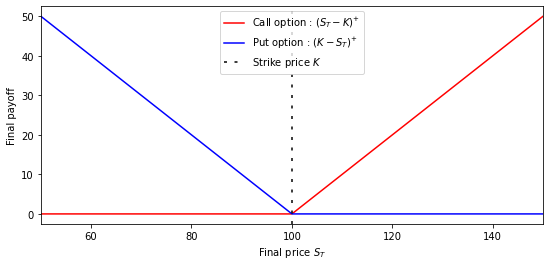

In [20]:
K = 100
payoff_call = PayOff(european_call,K = K)
payoff_put = PayOff(european_put,K = K)

ST = np.linspace(50,150,500).reshape((1,500))
fig,ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(ST.flatten(),payoff_call.compute_payoff(ST),color="red",label="Call option : $(S_T - K)^{+}$")
ax.plot(ST.flatten(),payoff_put.compute_payoff(ST),color="blue",label="Put option : $(K-S_T)^{+}$")
ax.set_ylabel("Final payoff")
ax.axvline(x=K,color="black",linestyle='--', dashes=(2, 5),label="Strike price $K$")
ax.set_xlabel("Final price $S_T$")
ax.set_xlim((50,150))
ax.legend()
plt.show()

## Monte Carlo Pricer class


In [21]:
class MonteCarloPricer:
  """
  Used to price a derivative using Monte-Carlo methods
  inputs : 
      PathGenerator object -> to gen the possible prices-curve that the asset can take
      PayOff object -> to compute the payoff of the prices for each case
  """
  def __init__(self,payoff : PayOff = None,payoff_func : callable = None,payoff_func_kwargs : dict = {},
               path_generator : PathGenerator = None, r :float= None,sigma :float = None,S0 :float = None,
               T : float = None,price_move_function : callable = None,price_move_function_args : dict = {}):

      if payoff is None and payoff_func is None:
          raise Exception("Incorrect 'Payoff' parameters passed")
      if path_generator is None and (sigma is None and S0 is None and T is None and r is None and price_move_function):
        raise Exception("Incorrect 'Path Generators' parameters passed")

      self.payoff = payoff if payoff else PayOff(payoff_func,**payoff_func_kwargs)

      self.path_generator = path_generator if path_generator else PathGenerator(S0 = S0,T = T,r=r,sigma = sigma,price_move_function = price_move_function,
                                                                                price_move_function_args=price_move_function_args)
      self.__r = self.path_generator.get_r()
      self.__T = self.path_generator.get_T()
      self.__sigma = self.path_generator.get_sigma()
      self.__S0 = self.path_generator.get_S0()

  def generate_path_and_payoff(self,n_paths:int,n_steps:int,epsilon_S:float=0.,plot_path_bool=False,seed=None):
      """
      Generate a prices matrix of shape (n_paths x n_steps) using the path_generator object
      Computes the payoff of each price trajectory using the payoff object
      returns the mean of the payoff
      """
      
      prices = self.path_generator.generate_path(n_paths=n_paths,n_steps=n_steps,S_impact=epsilon_S,seed=seed)
      payoffs = self.payoff.compute_payoff(prices)
      payoffs *= np.exp(-self.__r * self.__T)
      if plot_path_bool:  plot_path(prices)
      return prices,payoffs

  def compile_time_exec_results_paths(self,n_paths_list : np.ndarray, n_steps : int):
      """
      Price a derivative using a fixed number of steps and an array of "number of path"
      returns a dict n_path -> {price,error_at_95_confidence_interval,execution_time}
      """
      result = dict()
      for n_paths in n_paths_list:
        _,payoffs,exec_time = time_it_func(self.generate_path_and_payoff,n_paths=n_paths,n_steps=n_steps)
        error_95pc = compute_95ci_error(payoffs)
        result[n_paths] = {"price":payoffs.mean(),"error":error_95pc,"exec_time":exec_time}
      return result

  def compile_time_exec_results_steps(self,n_paths : int, n_steps_list : np.ndarray):
      """
      Price a derivative using a fixed number of steps and an array of "number of path"
      returns a dict n_path -> {price,error_at_95_confidence_interval,execution_time}
      """
      result = dict()
      for n_step in n_steps_list:
        _,payoffs,exec_time = time_it_func(self.generate_path_and_payoff,n_paths=n_paths,n_steps=n_step)
        error_95pc = compute_95ci_error(payoffs)
        result[n_step] = {"price":payoffs.mean(),"error":error_95pc,"exec_time":exec_time}
      return result

  def price_derivative(self,n_paths:int,n_steps:int)->float:
      """
      Price the derivative using Monte Carlo's Method
      """
      _,payoffs = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps)
      return payoffs.mean(),compute_95ci_error(payoffs)

  def quotient_greek(self,n_paths:int,n_steps:int,eps_scale:float = 1/8)->dict:
    """
    Compute the greeks of the derivative using the quotient_method
    """
    epsilon_S = self.__S0*eps_scale
    epsilon_sigma = self.__sigma*eps_scale

    seed = int(round(random.random(),5)*10000)

    _,payoffs_minus_e_s = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,epsilon_S = -epsilon_S,seed=seed)
    _,payoffs = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)
    _,payoffs_plus_e_s = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,epsilon_S = epsilon_S,seed=seed)

    delta = (payoffs_plus_e_s - payoffs_minus_e_s) / (2*epsilon_S)
    gamma = (payoffs_plus_e_s - 2*payoffs + payoffs_minus_e_s) / (epsilon_S*epsilon_S)

    self.path_generator.set_sigma(self.__sigma - epsilon_sigma)
    _,payoffs_minus_e_sigma = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)

    self.path_generator.set_sigma(self.__sigma + epsilon_sigma)
    _,payoffs_plus_e_sigma = self.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps,seed=seed)

    self.path_generator.set_sigma(self.__sigma)

    vega = (payoffs_plus_e_sigma - payoffs_minus_e_sigma) / (2*epsilon_sigma)

    return {"delta":(delta.mean(),compute_95ci_error(delta)),"vega":(vega.mean(),compute_95ci_error(vega)),"gamma":(gamma.mean(),compute_95ci_error(gamma))}

# Base model and Task n°1

### Theorie

#### Analytical (closed-form) solution

In [22]:
def closed_form_call_price(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_value = S0 * norm_cdf(d1) - K * np.exp(-r * T) * norm_cdf(d2)
    return call_value

def closed_form_call_delta(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm_cdf(d1)

def closed_form_call_gamma(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) / (S0 * sigma * np.sqrt(T))

def closed_form_call_vega(S0:float, K:float, T:float, r:float, sigma:float)->float:
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.pdf(d1) * np.sqrt(T) * S0

def norm_cdf(x:float)->float:
    return (1.0 + erf(x / np.sqrt(2.0))) / 2.0

#### Black-Scholes-Merton Call greeks ($\Delta,\gamma,\nu$)

In [23]:
def pathwise_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int,n_steps:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
    payoff = PayOff(european_call,K=95)

    mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

    prices,payoffs = mcpricer.generate_path_and_payoff(n_paths=n_paths,n_steps=n_steps)
    ST = prices[-1,:]

    indic_greater_than_K = lambda array : np.where(array[-1]>K,1.,0.)

    delta_array = np.exp(-r * T) * indic_greater_than_K(prices) * ST / S0

    vega_array = np.exp(-r * T) * ( np.log(ST/S0) - (r + sigma * sigma/2) * T) / sigma * indic_greater_than_K(prices) * ST 
    
    return {"delta":(delta_array.mean(),compute_95ci_error(delta_array)),"vega":(vega_array.mean(),compute_95ci_error(vega_array)),"gamma":(np.nan,np.nan)}

def likelihood_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    Z = np.random.normal(size=(n_paths))

    ST = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    discounted_payoff = np.exp(-r*T) *np.where(ST-K>=0,ST-K,0)

    delta_array =  discounted_payoff * Z / (S0*sigma*np.sqrt(T))

    gamma_array = discounted_payoff * ((Z*Z-1)/(S0*S0*sigma*sigma*T) - Z/(S0*S0*sigma*np.sqrt(T)))

    vega_array = discounted_payoff * ((Z*Z-1)/sigma - np.sqrt(T)*Z)
    
    return {"delta":(delta_array.mean(),compute_95ci_error(delta_array)),"vega":(vega_array.mean(),compute_95ci_error(vega_array)),"gamma":(gamma_array.mean(),compute_95ci_error(gamma_array))}

def quotient_call_BSM_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int)->dict:
    """
    Compute greeks for the call option in the black-scholes-merton model
    Can't compute gamma
    """

    Z = np.random.normal(size=(n_paths))

    epsilon_S = S0/100
    epsilon_sigma = sigma/100

    ST = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    ST_plus_eS = (S0+epsilon_S) * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)
    ST_minus_eS = (S0-epsilon_S) * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma-epsilon_sigma
    ST_minus_esigma = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma+2*epsilon_sigma
    ST_plus_esigma = S0 * np.exp((r-sigma*sigma/2)*T + sigma*np.sqrt(T)*Z)

    sigma = sigma-epsilon_sigma

    discounted_payoff = lambda prices : np.exp(-r*T) *np.where(prices-K>=0,prices-K,0)

    delta = (discounted_payoff(ST_plus_eS) - discounted_payoff(ST))/epsilon_S
    gamma = (discounted_payoff(ST_plus_eS) - 2*discounted_payoff(ST) + discounted_payoff(ST_minus_eS))/(2*epsilon_S)
    vega = (discounted_payoff(ST_plus_esigma) - discounted_payoff(ST))/epsilon_sigma
    
    return {"delta":(delta.mean(),compute_95ci_error(delta)),"vega":(vega.mean(),compute_95ci_error(vega)),"gamma":(gamma.mean(),compute_95ci_error(gamma))}

## Results

### Simulation vs Closed-form results

In [24]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

n_paths = 1000000

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(european_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = mcpricer.price_derivative(n_paths=n_paths,n_steps=2)


quotient_greek = quotient_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = n_paths)
quotient_greek_class_func = mcpricer.quotient_greek(n_paths=n_paths,n_steps=2)
pw_greek = pathwise_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = n_paths,n_steps=10)
likelihood_greek = likelihood_call_BSM_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,n_paths = n_paths)

print(f"\n{'SIMULATION RESULT':=^40}")

print(f"\n{'Price':_^40}")

print(f"Derivative fair value is {fair_value[0]:.3f} ± {fair_value[1]:.3f}")

print(f"\n{'Quotient method':_^40}")
print(f"Derivative delta is {quotient_greek.get('delta')[0]:.3f} ± {quotient_greek.get('delta')[1]:.3f}")
print(f"Derivative gamma is {quotient_greek.get('gamma')[0]:.3f} ± {quotient_greek.get('gamma')[1]:.5f}")
print(f"Derivative vega is {quotient_greek.get('vega')[0]:.3f} ± {quotient_greek.get('vega')[1]:.3f}")

print(f"\n{'Quotient method (class func)':_^40}")
print(f"Derivative delta is {quotient_greek_class_func.get('delta')[0]:.3f} ± {quotient_greek_class_func.get('delta')[1]:.3f}")
print(f"Derivative gamma is {quotient_greek_class_func.get('gamma')[0]:.3f} ± {quotient_greek_class_func.get('gamma')[1]:.5f}")
print(f"Derivative vega is {quotient_greek_class_func.get('vega')[0]:.3f} ± {quotient_greek_class_func.get('vega')[1]:.3f}")

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is {pw_greek.get('delta')[0]:.3f} ± {pw_greek.get('delta')[1]:.3f}")
print(f"Derivative gamma is {pw_greek.get('gamma')[0]:.3f} ± {pw_greek.get('gamma')[1]:.5f}")
print(f"Derivative vega is {pw_greek.get('vega')[0]:.3f} ± {pw_greek.get('vega')[1]:.3f}")

print(f"\n{'Likelihood method':_^40}")
print(f"Derivative delta is {likelihood_greek.get('delta')[0]:.3f} ± {likelihood_greek.get('delta')[1]:.3f}")
print(f"Derivative gamma is {likelihood_greek.get('gamma')[0]:.3f} ± {likelihood_greek.get('gamma')[1]:.5f}")
print(f"Derivative vega is {likelihood_greek.get('vega')[0]:.3f} ± {likelihood_greek.get('vega')[1]:.3f}")

fair_value = closed_form_call_price(r=r,sigma = sigma,T=T,S0=S0,K=K)
delta = closed_form_call_delta(r=r,sigma = sigma,T=T,S0=S0,K=K)
gamma = closed_form_call_gamma(r=r,sigma = sigma,T=T,S0=S0,K=K)
vega = closed_form_call_vega(r=r,sigma = sigma,T=T,S0=S0,K=K)

print(f"\n{'CLOSED-FORM RESULT':=^40}\n")

print(f"Derivative fair value is {fair_value:.3f}\n")
print(f"Derivative delta is {delta:.3f}")
print(f"Derivative gamma is {gamma:.3f}")
print(f"Derivative vega is {vega:.3f}")


===========SIMULATION RESULT============

_________________Price__________________
Derivative fair value is 18.141 ± 0.053

____________Quotient method_____________
Derivative delta is 0.632 ± 0.001
Derivative gamma is 0.005 ± 0.00008
Derivative vega is 37.811 ± 0.189

______Quotient method (class func)______
Derivative delta is 0.662 ± 0.001
Derivative gamma is 0.009 ± 0.00004
Derivative vega is 39.844 ± 0.143

____________Pathwise method_____________
Derivative delta is 0.635 ± 0.001
Derivative gamma is nan ± nan
Derivative vega is 37.447 ± 0.179

___________Likelihood method____________
Derivative delta is 0.629 ± 0.003
Derivative gamma is 0.010 ± 0.00016
Derivative vega is 38.523 ± 0.627

===========CLOSED-FORM RESULT===========

Derivative fair value is 18.023

Derivative delta is 0.627
Derivative gamma is 0.009
Derivative vega is 37.842


### Time of execution and precision vs number of paths/steps

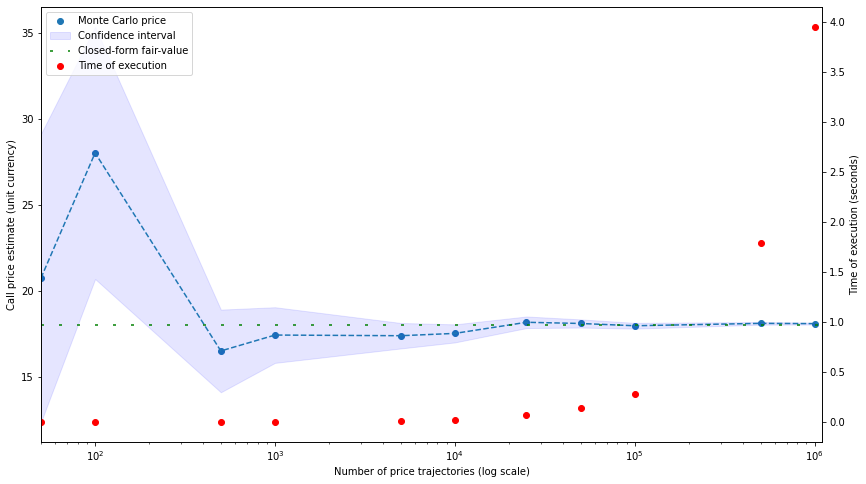

,50,100,500,1000,5000,10000,25000,50000,100000,500000,1000000
price,20.750903,28.038629,16.506262,17.431947,17.393413,17.528769,18.176071,18.105997,17.973669,18.112733,18.097553
error,8.396309,7.341027,2.407276,1.620551,0.742156,0.525828,0.336555,0.237733,0.167920,0.075284,0.053246
exec_time,0.000782,0.000647,0.001745,0.003037,0.016264,0.027591,0.068060,0.145095,0.282105,1.786036,3.946907
rel_error,15.135987,55.571792,-8.415320,-3.279175,-3.492983,-2.741959,0.849579,0.460778,-0.273443,0.498149,0.413924


In [25]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(european_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

n_paths_list = np.array([50,100,500,1000,5000,10000,25000,50000,100000,500000,1000000])
n_steps = 2

res = mcpricer.compile_time_exec_results_paths(n_paths_list,n_steps = n_steps)
closed_form_fv = closed_form_call_price(r=r,sigma = sigma,T=T,S0=S0,K=K)

price = np.array([value["price"] for value in res.values()])
error_95c =  np.array([value["error"] for value in res.values()])
exec_time = np.array([value["exec_time"] for value in res.values()])

fig,ax = plt.subplots(1,1,figsize=  (14,8))

ax_time = ax.twinx()

ax.set_xlabel("Number of price trajectories (log scale)")
ax.set_ylabel("Call price estimate (unit currency)")

ax.set_xscale('log')
ax.set_xlim((n_paths_list.min(),n_paths_list.max()*1.1))
ax.plot(n_paths_list,price,linestyle="dashed")
ax.scatter(n_paths_list,price,label="Monte Carlo price")

ax.fill_between(n_paths_list, (price-error_95c) , (price+error_95c), color='b', alpha=.1,label="Confidence interval")
ax.axhline(y=closed_form_fv,color="green",linestyle='--', dashes=(2, 10),label="Closed-form fair-value")

ax_time.set_ylabel("Time of execution (seconds)")
ax_time.scatter(n_paths_list,exec_time,color="red",label="Time of execution")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_time.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")

plt.show()
tab_res = pd.DataFrame(res)
tab_res.loc["rel_error",:] = (tab_res.loc["price",:] - closed_form_fv)/closed_form_fv *100
tab_res = tab_res.apply(lambda x : round(x,6))
display(tab_res)

### Step size impact in finite difference method

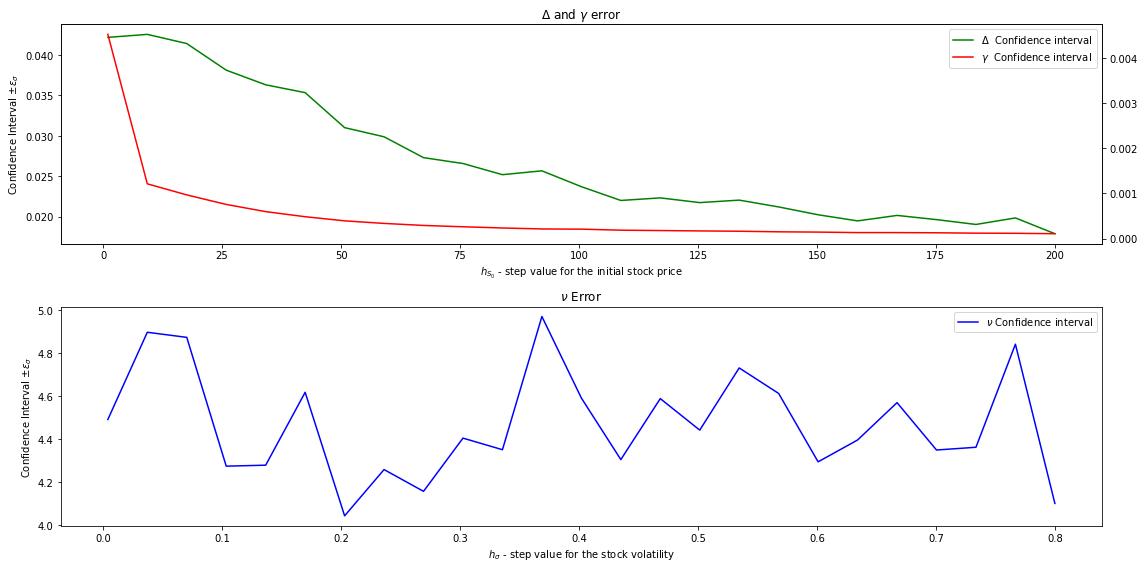

In [26]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(european_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

n_paths = 1000
n_steps = 2

delta_err = []
gamma_err = []
vega_err = []

scale_list = np.linspace(0.01,2,25)
h_s_list = []
h_sigma_list = []
for e in scale_list:
  quotient_greek_class_func = mcpricer.quotient_greek(n_paths=n_paths,n_steps=2,eps_scale = e)
  delta_err.append(quotient_greek_class_func.get("delta")[1])
  gamma_err.append(quotient_greek_class_func.get("gamma")[1])
  vega_err.append(quotient_greek_class_func.get("vega")[1])

  h_s_list.append(S0 * e)
  h_sigma_list.append(sigma * e)

fig,axs = plt.subplots(2,1,figsize = (16,8),sharex=False)
ax = axs[0]
ax.plot(h_s_list,delta_err,label = "$\Delta$  Confidence interval",color="green")
ax.set_title("$\Delta$ and $\gamma$ error")
ax.set_xlabel("$h_{S_0}$ - step value for the initial stock price")
ax.set_ylabel("Confidence Interval $\pm \epsilon_{\Delta}$")
ax_twinx = ax.twinx()
ax_twinx.plot(h_s_list,gamma_err,label = "$\gamma$  Confidence interval",color="red")
ax.set_ylabel("Confidence Interval $\pm \epsilon_{\sigma}$")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_twinx.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper right")

ax = axs[1]
ax.plot(h_sigma_list,vega_err,label = "$\\nu$ Confidence interval",color="blue")
ax.set_title("$\\nu$ Error")
ax.set_xlabel("$h_{\sigma}$ - step value for the stock volatility")
ax.set_ylabel("Confidence Interval $\pm \epsilon_{\sigma}$")
ax.legend()

plt.tight_layout()
plt.show()

# Task 2 : Asian/Stochastic Volatility Options

## Pricing the asian call using BSM model

### Arithmetic Asian Call

In [27]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

n_steps = 1000
n_paths = 10000

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(arithmetic_asian_call,K=K)

arithmetic_asian_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = arithmetic_asian_BSM_pricer.price_derivative(n_paths=n_paths,n_steps=n_steps)
print(f"Derivative fair value is {fair_value[0]:.3f} ± {fair_value[1]:.3f}")

Derivative fair value is 10.346 ± 0.323


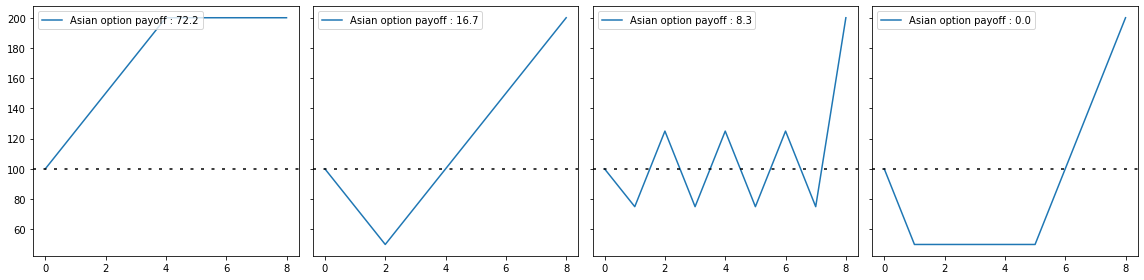

In [28]:
fig,axs = plt.subplots(1,4,figsize=(16,4),sharey=True)
payoff = PayOff(arithmetic_asian_call,K=100)
paths = [[100,125,150,175,200,200,200,200,200],[100,75,50,75,100,125,150,175,200],[100,75,125,75,125,75,125,75,200],[100,50,50,50,50,50,100,150,200]]
paths = np.array(paths,dtype=float)
for i in range(4):
    ax = axs[i]
    path = paths[i]
    p = f"{payoff.compute_payoff(path):.1f}"
    ax.plot(path,label=f"Asian option payoff : {p}")
    ax.axhline(y=100,color="black",linestyle='--', dashes=(2, 5),)
    ax.legend(loc="upper left")
plt.tight_layout()
plt.show()

### Geometric Asian Call

In [29]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

n_steps = 1000
n_paths = 10000

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(geometric_asian_call,K=K)

geometric_asian_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = geometric_asian_BSM_pricer.price_derivative(n_paths=n_paths,n_steps=n_steps)
print(f"Derivative fair value is {fair_value[0]:.3f} ± {fair_value[1]:.3f}")

Derivative fair value is 9.399 ± 0.299


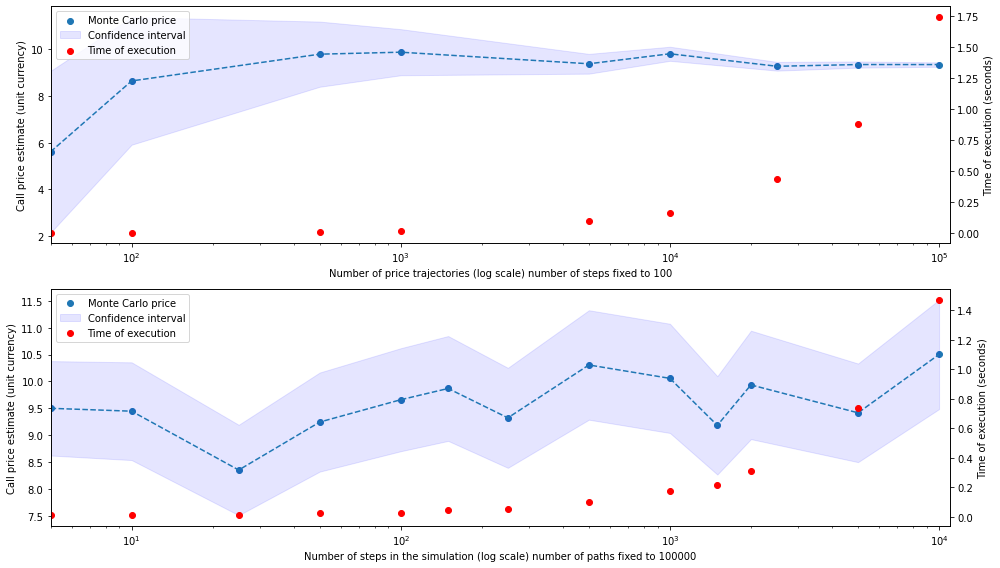

,5,10,25,50,100,150,250,500,1000,1500,2000,5000,10000
price,9.500581,9.446865,8.351531,9.244464,9.660375,9.869720,9.322850,10.307445,10.058050,9.182845,9.936245,9.416325,10.503581
error,0.878743,0.909879,0.841549,0.922382,0.958862,0.975951,0.930879,1.018861,1.016684,0.915365,1.009320,0.917868,1.017499
exec_time,0.011234,0.011229,0.012987,0.026734,0.029403,0.047594,0.053005,0.098306,0.172175,0.219236,0.308005,0.740134,1.472058
rel_error,-47.286211,-47.584250,-53.661690,-48.707267,-46.399592,-45.238046,-48.272344,-42.809342,-44.193101,-49.049163,-44.868935,-47.753699,-41.721080


In [30]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(geometric_asian_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

n_paths_list = np.array([50,100,500,1000,5000,10000,25000,50000,100000])
n_steps = 100

n_paths = 1000
n_steps_list = np.array([5,10,25,50,100,150,250,500,1000,1500,2000,5000,10000])

res = mcpricer.compile_time_exec_results_paths(n_paths_list,n_steps = n_steps)

price = np.array([value["price"] for value in res.values()])
error_95c =  np.array([value["error"] for value in res.values()])
exec_time = np.array([value["exec_time"] for value in res.values()])

fig,axs = plt.subplots(2,1,figsize=  (14,8))

ax = axs[0]
ax_time = ax.twinx()

ax.set_xlabel("Number of price trajectories (log scale) number of steps fixed to 100")
ax.set_ylabel("Call price estimate (unit currency)")

ax.set_xscale('log')
ax.set_xlim((n_paths_list.min(),n_paths_list.max()*1.1))
ax.plot(n_paths_list,price,linestyle="dashed")
ax.scatter(n_paths_list,price,label="Monte Carlo price")

ax.fill_between(n_paths_list, (price-error_95c) , (price+error_95c), color='b', alpha=.1,label="Confidence interval")

ax_time.set_ylabel("Time of execution (seconds)")
ax_time.scatter(n_paths_list,exec_time,color="red",label="Time of execution")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_time.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")


res = mcpricer.compile_time_exec_results_steps(n_paths,n_steps_list = n_steps_list)

price = np.array([value["price"] for value in res.values()])
error_95c =  np.array([value["error"] for value in res.values()])
exec_time = np.array([value["exec_time"] for value in res.values()])

ax = axs[1]
ax_time = ax.twinx()

ax.set_xlabel("Number of steps in the simulation (log scale) number of paths fixed to 100000")
ax.set_ylabel("Call price estimate (unit currency)")

ax.set_xscale('log')
ax.set_xlim((n_steps_list.min(),n_steps_list.max()*1.1))
ax.plot(n_steps_list,price,linestyle="dashed")
ax.scatter(n_steps_list,price,label="Monte Carlo price")

ax.fill_between(n_steps_list, (price-error_95c) , (price+error_95c), color='b', alpha=.1,label="Confidence interval")

ax_time.set_ylabel("Time of execution (seconds)")
ax_time.scatter(n_steps_list,exec_time,color="red",label="Time of execution")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax_time.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="upper left")
plt.tight_layout()
plt.show()
tab_res = pd.DataFrame(res)
tab_res.loc["rel_error",:] = (tab_res.loc["price",:] - closed_form_fv)/closed_form_fv *100
tab_res = tab_res.apply(lambda x : round(x,6))
display(tab_res)

In [31]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})
payoff = PayOff(arithmetic_asian_call,K=K)

mcpricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

n_paths_list = np.array([100,1000,10000,100000,1000000])
n_steps = 100

res = mcpricer.compile_time_exec_results_paths(n_paths_list,n_steps = n_steps)
tab_res = pd.DataFrame(res)
tab_res = tab_res.apply(lambda x : round(x,6))
display(tab_res)

,100,1000,10000,100000,1000000
price,7.523834,9.174152,10.512888,10.176048,10.129391
error,2.431052,0.918961,0.335124,0.101884,0.032087
exec_time,0.007443,0.020390,0.158175,1.655462,18.141809


### Lévy's approximation

In [32]:
def param_levy(S0:float,r:float,T:float,sigma:float,n_steps:int):
  TT = np.linspace(0,T,n_steps+1)
  m1 = np.mean(S0*np.exp((r)*TT))

  h = T/(n_steps+1)

  m2 = 0
  for i in range(n_steps+1):
    sum_exp=0
    for j in range(i+1,n_steps+1):
      sum_exp+=np.exp(r*h*(j-i))
    
    m2 += S0*S0*np.exp((2*r+sigma*sigma)*i*h) * (1+2*sum_exp)



  m2 = np.mean(m2/((n_steps+1)*(n_steps+1)))

  
  return(np.log(m1*m1/np.sqrt(m2)),np.sqrt(np.log(m2/(m1*m1))))

a_levy,b_levy = param_levy(S0=S0,r=r,T=T,sigma=sigma,n_steps=1000)

In [33]:
path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})   

paths = path_generator.generate_path(n_paths=n_paths, n_steps=n_steps,S_impact=0)
TT = np.linspace(0,T,n_steps+1)
m1 = np.mean(S0*np.exp((r)*TT))

h = T/(n_steps+1)

m2 = 0
for i in range(n_steps+1):
  sum_exp=0
  for j in range(i+1,n_steps+1):
    sum_exp+=np.exp(r*h*(j-i))
  
  m2 += S0*S0*np.exp((2*r+sigma*sigma)*i*h) * (1+2*sum_exp)



m2 = np.mean(m2/((n_steps+1)*(n_steps+1)))

a , b = a_levy,b_levy
from scipy.stats import norm
A=np.mean(np.mean(paths,axis=0))
def C(A, m=0, N=1000):
    discount_factor = np.exp(-r * (T))
    d1 = (0.5 * np.log(m2) - np.log(K - A * (m + 1) / (N + 1))) / b
    d2 = d1 - b
    
    C_value = discount_factor * (m1 * norm.cdf(d1) - (K - A * (m + 1) / (N + 1)) * norm.cdf(d2))
    
    return C_value

print(C(A))

10.267014701479493


In [34]:
Z = np.random.normal(size=10000)
levy_price = np.exp(-r*T)*np.mean(np.where(np.exp(a_levy+b_levy*Z)-K>0,np.exp(a_levy+b_levy*Z)-K,0))
print('Levy price with Monte Carlo : ', levy_price, ' ± ', compute_95ci_error(np.exp(-r*T)*np.where(np.exp(a_levy+b_levy*Z)-K>0,np.exp(a_levy+b_levy*Z)-K,0)) )

Levy price with Monte Carlo :  10.388009094357185  ±  0.3151927513857078


## Estimating the greeks

### Pathwise method

In [35]:
def pathwise_call_BSM_asian_greek(S0:float,K:float,sigma:float,T:float,r:float,n_paths:int,n_steps:int,opt_type:str)->dict:


    path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})

    paths = path_generator.generate_path(n_paths=n_paths, n_steps=n_steps,S_impact=0)

    if opt_type=='arithmetic':
      mean_ST = np.mean(paths,axis=0)
    if opt_type=='geometric':
      mean_ST = np.power(np.prod(paths,axis=0),1/n_steps)
    mean_ST = np.where(mean_ST>K, mean_ST,0)

    delta = np.exp(-r*T)*(mean_ST)/S0

    TT = np.zeros((n_steps+1,n_paths))

    for i in range(n_paths):
      TT[:,i]= np.linspace(0,T,n_steps+1)

    vega_der = ( np.log(paths/S0) - (r + sigma * sigma/2) * TT) / sigma # mettre les Ti, pas T_exp

    if opt_type=='arithmetic':
      vega_l = np.mean(vega_der*paths,axis=0)
    if opt_type=='geometric':
      vega_l = (1/(n_steps))*np.prod(paths,axis = 0)*np.sum(vega_der,axis=0)*np.power(np.prod(paths,axis=0),1/(n_steps)-1)

    vega_l = np.exp(-r * T) * np.where(mean_ST>K, vega_l,0)

    vega = vega_l.mean()

    return {"delta":(delta.mean(),compute_95ci_error(delta)),"vega":(vega,compute_95ci_error(vega_l)),"gamma":0}

### Results

In [36]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4
K = 100

n_steps = 1000
n_paths = 10000

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_black_scholes,price_move_function_args={"r":r,"sigma":sigma})

print(f"\n{'SIMULATION RESULTS':=^40}")

print(f"\n{'ARITHMETIC ASIAN CALL':^40}")

payoff = PayOff(arithmetic_asian_call,K=K)

arithmetic_asian_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

arithmetic_asian_quotien_greek_ = arithmetic_asian_BSM_pricer.quotient_greek(n_paths=n_paths,n_steps=n_steps)

print(f"{'Greeks (quotient method)':_^40}\n")
print(f"Derivative delta is {arithmetic_asian_quotien_greek_.get('delta')[0]:.3f} ± {arithmetic_asian_quotien_greek_.get('delta')[1]:.3f}")
print(f"Derivative gamma is {arithmetic_asian_quotien_greek_.get('gamma')[0]:.3f} ± {arithmetic_asian_quotien_greek_.get('gamma')[1]:.4f}")
print(f"Derivative vega is {arithmetic_asian_quotien_greek_.get('vega')[0]:.3f} ± {arithmetic_asian_quotien_greek_.get('vega')[1]:.3f}")


pw_greek = pathwise_call_BSM_asian_greek(S0=S0,T=T,r=r,K=K,sigma=sigma, n_paths = 10000,n_steps=100,opt_type='arithmetic')

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is {pw_greek.get('delta')[0]:.3f} ± {pw_greek.get('delta')[1]:.3f}")
print(f"Derivative vega is {pw_greek.get('vega')[0]:.3f} ± {pw_greek.get('vega')[1]:.3f}")



print(f"\n{'GEOMETRIC ASIAN CALL':^40}")

payoff = PayOff(geometric_asian_call,K=K)


geometric_asian_BSM_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)

geometric_asian_quotien_greek_ = geometric_asian_BSM_pricer.quotient_greek(n_paths=n_paths,n_steps=n_steps)

print(f"{'Greeks (quotient method)':_^40}\n")
print(f"Derivative delta is {geometric_asian_quotien_greek_.get('delta')[0]:.3f} ± {geometric_asian_quotien_greek_.get('delta')[1]:.3f}")
print(f"Derivative gamma is {geometric_asian_quotien_greek_.get('gamma')[0]:.3f} ± {geometric_asian_quotien_greek_.get('gamma')[1]:.4f}")
print(f"Derivative vega is {geometric_asian_quotien_greek_.get('vega')[0]:.3f} ± {geometric_asian_quotien_greek_.get('vega')[1]:.3f}")


pw_greek = pathwise_call_BSM_asian_greek(S0=S0,T=T,r=r,K=K,sigma=sigma, n_paths = 10000,n_steps=100,opt_type='geometric')

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is {pw_greek.get('delta')[0]:.3f} ± {pw_greek.get('delta')[1]:.3f}")
print(f"Derivative vega is {pw_greek.get('vega')[0]:.3f} ± {pw_greek.get('vega')[1]:.3f}")


===========SIMULATION RESULTS===========

         ARITHMETIC ASIAN CALL          
________Greeks (quotient method)________

Derivative delta is 0.560 ± 0.010
Derivative gamma is 0.016 ± 0.0005
Derivative vega is 22.057 ± 0.907

____________Pathwise method_____________
Derivative delta is 0.566 ± 0.012
Derivative vega is 22.226 ± 0.938

          GEOMETRIC ASIAN CALL          
________Greeks (quotient method)________

Derivative delta is 0.540 ± 0.010
Derivative gamma is 0.016 ± 0.0005
Derivative vega is 18.599 ± 0.803

____________Pathwise method_____________
Derivative delta is 0.649 ± 0.012
Derivative vega is 17.653 ± 0.875


## Pricing the asian call using Heston model

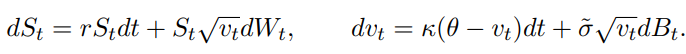

In [37]:
S0 = 100
r = 0.05
T = 1
sigma = 0.4 # sigma = sqrt(v0)
K = 100
kappa = 1.5
theta = 0.5
vol_of_vol = 0.3
rho = 0.1 # covariation between brownian motion

# kappa = 0.
# vol_of_vol = 0.

path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})

### Pathwise method

In [38]:
def pathwise_call_Heston_greek(S0:float,K:float,sigma:float,T:float,r:float,k:float,v:float,theta:float,n_paths:int,n_steps:int,opt_type:str)->dict:


    path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})

    paths = path_generator.generate_path(n_paths=n_paths, n_steps=n_steps,S_impact=0)

    if opt_type=='arithmetic':
      mean_ST = (1/n_steps)*np.sum(paths,axis=0)
    if opt_type=='geometric':
      mean_ST = np.power(np.prod(paths,axis=0),1/n_steps)
    mean_ST = np.where(mean_ST>K, mean_ST,0)

    delta = np.exp(-r*T)*(mean_ST)/S0

    return {"delta":(delta.mean(),compute_95ci_error(delta)),"vega":0,"gamma":0}

### Results

In [39]:
print(f"\n{'SIMULATION RESULTS':=^40}")

print(f"\n{'ARITHMETIC ASIAN CALL':^40}")


payoff = PayOff(arithmetic_asian_call,K=K)


asian_heston_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = asian_heston_pricer.price_derivative(n_paths=10000,n_steps=100)

asian_heston_quotien_greek_ = asian_heston_pricer.quotient_greek(n_paths=100000,n_steps=100)


print(f"\nOption fair-value is : {fair_value[0]:.3f} ± {fair_value[1]:.3f}")
print(f"\n{'Greeks (quotient method)':_^40}")
print(f"Derivative delta is : {asian_heston_quotien_greek_.get('delta')[0]:.3f} ± {asian_heston_quotien_greek_.get('delta')[1]:.3f}")
print(f"Derivative gamma is : {asian_heston_quotien_greek_.get('gamma')[0]:.3f} ± {asian_heston_quotien_greek_.get('gamma')[1]:.5f}")
print(f"Derivative vega is : {asian_heston_quotien_greek_.get('vega')[0]:.3f} ± {asian_heston_quotien_greek_.get('vega')[1]:.3f}")


pw_greek = pathwise_call_Heston_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,k=kappa,v=0,theta=theta, n_paths = 10000,n_steps=100,opt_type='arithmetic')

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is : {pw_greek.get('delta')[0]:.3f} ± {pw_greek.get('delta')[1]:.3f}")


#-----------------

print(f"\n{'GEOMETRIC ASIAN CALL':^40}")

payoff = PayOff(geometric_asian_call,K=K)


asian_heston_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
fair_value = asian_heston_pricer.price_derivative(n_paths=10000,n_steps=100)

asian_heston_quotien_greek_ = asian_heston_pricer.quotient_greek(n_paths=100000,n_steps=100)

print(f"\nOption fair-value is : {fair_value[0]:.3f} ± {fair_value[1]:.3f}")
print(f"\n{'Greeks (quotient method)':_^40}")
print(f"Derivative delta is : {asian_heston_quotien_greek_.get('delta')[0]:.3f} ± {asian_heston_quotien_greek_.get('delta')[1]:.3f}")
print(f"Derivative gamma is : {asian_heston_quotien_greek_.get('gamma')[0]:.3f} ± {asian_heston_quotien_greek_.get('gamma')[1]:.5f}")
print(f"Derivative vega is : {asian_heston_quotien_greek_.get('vega')[0]:.3f} ± {asian_heston_quotien_greek_.get('vega')[1]:.3f}")


pw_greek = pathwise_call_Heston_greek(S0=S0,T=T,r=r,K=K,sigma=sigma,k=kappa,v=0,theta=theta, n_paths = 10000,n_steps=100,opt_type='geometric')

print(f"\n{'Pathwise method':_^40}")
print(f"Derivative delta is : {pw_greek.get('delta')[0]:.3f} ± {pw_greek.get('delta')[1]:.3f}")


===========SIMULATION RESULTS===========

         ARITHMETIC ASIAN CALL          

Option fair-value is : 13.103 ± 0.455

________Greeks (quotient method)________
Derivative delta is : 0.570 ± 0.004
Derivative gamma is : 0.013 ± 0.00014
Derivative vega is : 11.990 ± 0.196

____________Pathwise method_____________
Derivative delta is : 0.591 ± 0.013

          GEOMETRIC ASIAN CALL          

Option fair-value is : 11.386 ± 0.384

________Greeks (quotient method)________
Derivative delta is : 0.534 ± 0.004
Derivative gamma is : 0.013 ± 0.00014
Derivative vega is : 10.464 ± 0.172

____________Pathwise method_____________
Derivative delta is : 0.628 ± 0.012


## Implied parameters Heston Model

In [40]:
# We now want to find the implied parameter so as to match the market price
from scipy.optimize import minimize

def Heston_Euro_Call_Price(S0, r, T, K, sigma, kappa, vol_of_vol, theta, pho):
    """
    inputs : kappa, vol_of_vol, theta, pho (Heston model parameter)
    constants : K,S0,r,T (fixed parameter of the option)
    output : Heston Price
    """
    # Generate path with Heston SDE
    path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":kappa,"vol_of_vol":vol_of_vol,"theta":theta,"rho":rho})
    # Price of classical european call
    payoff = PayOff(european_call,K=K)
    european_call_heston_pricer = MonteCarloPricer(path_generator=path_generator,payoff=payoff)
    Heston_value = european_call_heston_pricer.price_derivative(n_paths=10000,n_steps=2)

    return Heston_value



In [41]:
# Now we will compute these implied parameter for different option (on the same asset) and compute the sum squared error loss function

# import urllib library
from urllib.request import urlopen
import json
import datetime

# Get the json of Apple Option
url = "https://query1.finance.yahoo.com/v7/finance/options/AAPL"
response = urlopen(url)
data_json = json.loads(response.read())

# Get information about the underlying
Underlyingdata = data_json['optionChain']
Underlyingdata= Underlyingdata['result']
Underlyingdata = Underlyingdata[0]
Underlyingdata = Underlyingdata['quote']

# Underlying price (AAPL USD)
underlying_price = Underlyingdata['regularMarketPrice']

# Current time
dataMarket = data_json['optionChain']
Market_time = dataMarket['result'][0]['quote']['regularMarketTime']

# Collect data about all available options
data = data_json['optionChain']
data = data['result']
data = data[0]
data = data['options'][0]
data = data['calls']

In [42]:
# Loss Function : SSE

r = 0.05
S0 = underlying_price
t = datetime.datetime.fromtimestamp(Market_time)

def Loss_Market_Hestion_Price(sigma, kappa, vol_of_vol, theta, pho):
  """
  We know compute the loss function : sum of squared error for every market price
  """
  all_error = []

  for i in range(len(data)):

    # Get the information about the call :
    Info = data[i]
    K = Info['strike']
    Market_Price = Info['lastPrice']
    date_expiration = Info['expiration']
    T = datetime.datetime.fromtimestamp(date_expiration)
    tau = (T-t).days/252
    # error 
    err = Heston_Euro_Call_Price(S0, r, tau, K, sigma, kappa, vol_of_vol, theta, pho)[0] - Market_Price
    all_error.append(err**2)
  

  return np.sum(all_error)



def Get_Heston_Implied_Param_Loss():
  """
    In this case we use the loss function SSE to compute the implied parameters
    We want to find the parameters which minimize the previous loss function

    inputs : none
    output : implied parameters kappa, vol_of_vol, theta, pho (Heston model parameter)
  """
  # Contsraints

  def constraint1(x):
    # Heston constraints : 2*kappa*theta - vol_of_vol**2
    return 2*x[1]*x[3] - x[2]**2
    
  # Minimize the error between model and market price usign scipy
  func = lambda x : Loss_Market_Hestion_Price(x[0], x[1], x[2], x[3], x[4])
  con1 = {'type': 'ineq', 'fun': constraint1}
  bnds = ((0, 100), (-100, 100), (0, 100), (-100, 100), (-100, 100))
  # X_0 = np.random.random(5)*10
  # Classical values of these parameters 
  X_0 = [0.1, 2, 2.3e-3, 5e-5, -2e-3]
  result = minimize(func, x0=X_0, method ="SLSQP", bounds=bnds, constraints=con1)   
  x_opt = result.x 


  return x_opt 

In [43]:
x_opt = Get_Heston_Implied_Param_Loss()

In [44]:
print("Implied parameters fitted on {} option price: ".format(len(data)))
print(f"sigma_0 : {x_opt[0]:.5f}")
print(f"kappa : {x_opt[1]:.5f}")
print(f"vol of vol : {x_opt[2]:.5f}")
print(f"theta : {x_opt[3]:.5f}")
print(f"pho : {x_opt[4]:.5f} \n")

Implied parameters fitted on 73 option price: 
sigma_0 : 0.10000
kappa : 2.00000
vol of vol : 0.00230
theta : 0.00005
pho : -0.00200 



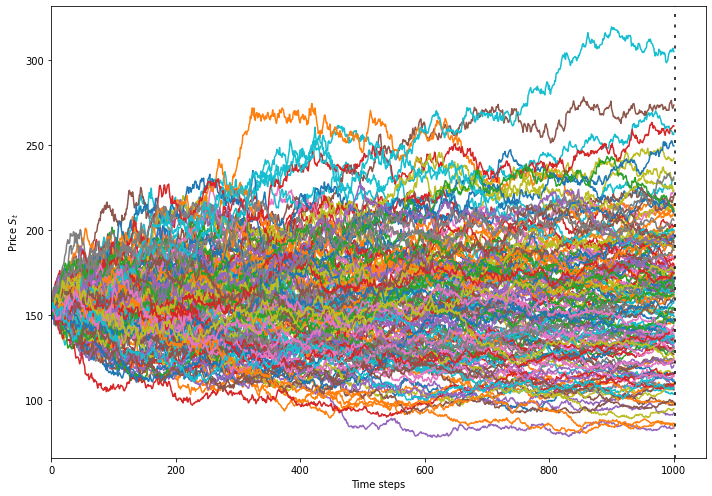

In [45]:
# We now generate path using these implied parameters 
path_generator = PathGenerator(S0,r,T,sigma,price_move_function = price_move_Heston,price_move_function_args={"r":r,"kappa":x_opt[1],"vol_of_vol":x_opt[2],"theta":x_opt[3],"rho":x_opt[4]})
plot_path(path_generator.generate_path(n_paths = 5000,n_steps = 1000),scale=1.5, plot_limit_path = 150, xlabel = "Time steps",ylabel = "Price $S_t$")